# Final Project Data Analytics and IoT
## GeoLife Trajectories 

In [ ]:
import numpy as np
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0
from tensorflow import keras
import matplotlib.pyplot as plt
import scikitplot

from prepare_data import prepare_data
import lstm_time_series
import transformer_classifier
from plot_model_history import plot_model_history
from generate_tableau_csv import generate_tableau_csv

## Data Exploration
--TODO: Write description of data... plt files, text with labels...
--TODO: Create chart displaying data from one of the plt files, maybe using geopandas:
https://stackoverflow.com/questions/63644131/how-to-use-geopandas-to-plot-latitude-and-longitude-on-a-more-detailed-map-with

## Data Preparation
Create a pandas dataframe with every data point that has a label. Uncomment and run below cell to create.

In [2]:
# add_labels()

## Data Cleaning
Because of the way the data was collected, there are some discontinuous entries. Randomly large time gaps exist, as well as adjacent points that have different labels.

Also, we need to prepare the data for the model training.

In this step, we divide the data into sequences of 100 points. Each sequence will have smaller time-steps between points, and will have only one label.

We also converted the latitude and longitude into x, y, and z coordinates for easier deep learning training, and calculated the distance between subsequent point, for velocity information.

We save the resulting arrays for easier testing.

Uncomment and run to create.

In [3]:
# sequence_data, label_array = create_sequences()
# with open('seq_labels.npz', 'wb') as f:
#     np.savez(f, sequence_data, label_array)

## Prepare data for training
Split data into train and test sets, scale using min-max scalar

In [4]:
x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm, _, _ = prepare_data('lstm')
input_shape_lstm = x_train_lstm.shape[1:]
output_shape_lstm = y_train_lstm.shape[1:][0]

x_train_transformer, \
    y_train_transformer, \
    x_test_transformer, \
    y_test_transformer, _, num_classes = prepare_data('transformer')
input_shape_transformer = x_train_transformer.shape[1:]

## Build the time series Model use LSTM
Model Building: Create a multi-layer LSTM network using the extracted features and normalized values as input. The output layer should have as many nodes as the number of features you want to predict (in this case, 3).

Training: Train the model using a suitable optimizer and loss function on the preprocessed data. Monitor the accuracy of the model on a validation set during training.

Testing: Finally, test the model on unseen data to evaluate its performance in predicting the GPS trajectory.

In [5]:
lstm_model = lstm_time_series.build_model(input_shape_lstm, output_shape_lstm)

Uncomment below to train LSTM and save weights

In [6]:
# lstm_time_series.run_model()

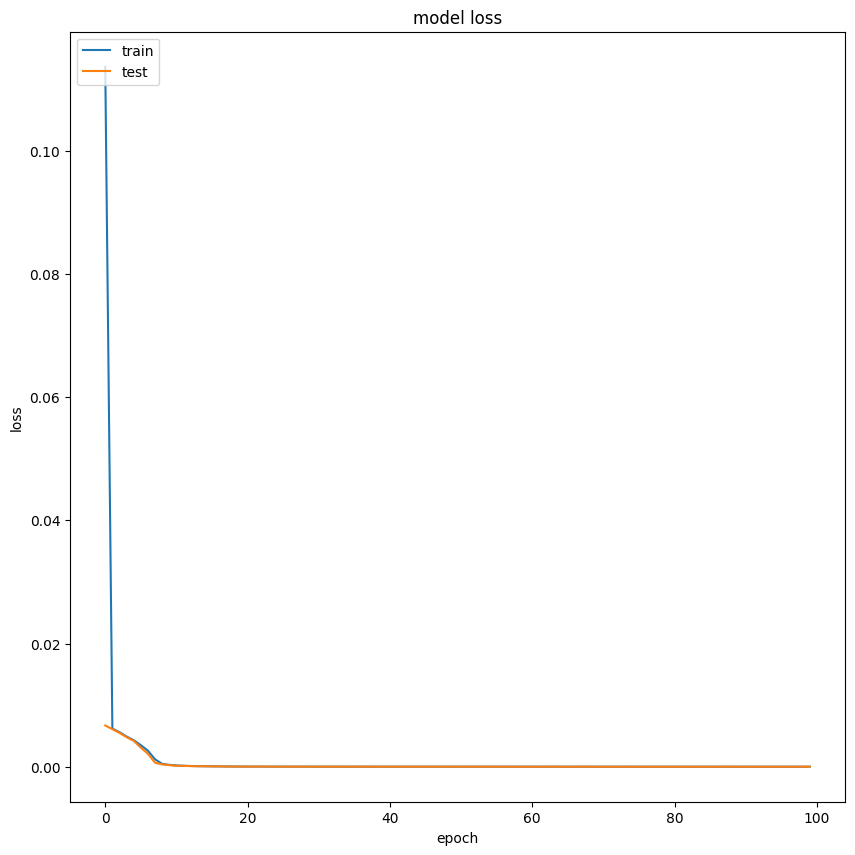

In [7]:
plot_model_history('lstm_history.txt')

In [8]:
# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4))

# Load the saved model
lstm_model.load_weights('lstm_model.h5')

lstm_model.evaluate(x_test_lstm, y_test_lstm, verbose=1)

2023-02-23 12:11:59.120956: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-23 12:11:59.549467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:11:59.610266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:11:59.653271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:11:59.701333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 2s 5ms/step - loss: 1.1179e-05


1.11793888208922e-05

4/4 [==============================] - 1s 13ms/step


2023-02-23 12:12:06.277146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:12:06.331704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:12:06.359224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:12:06.385449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


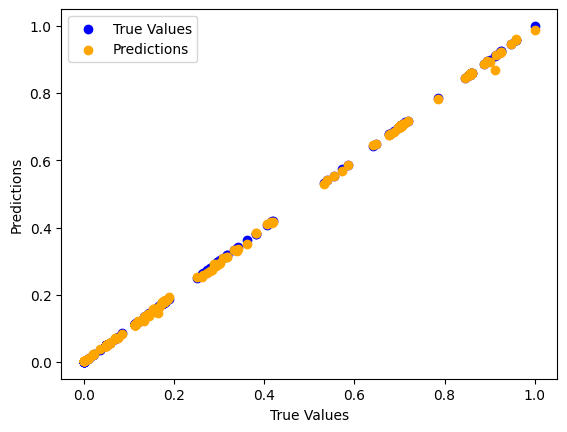

In [9]:
# Get the predicted values for the first 50 points in the test dataset
n = 100
x_sample = x_test_lstm[:n]
y_true = y_test_lstm[:n]
y_pred = lstm_model.predict(x_sample)

# Create a scatter plot comparing the predicted values to the true values
plt.scatter(y_true, y_true, c='blue', label='True Values')
plt.scatter(y_true, y_pred, c='orange', label='Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

In [10]:
transformer_model = transformer_classifier.build_model(input_shape_transformer,
                                                       num_heads=4,
                                                        num_transformer_blocks=4,
                                                        dropout=0.25)

In [11]:
# transformer_classifier.run_model()

In [12]:
transformer_model.load_weights('transformer_model.h5')
transformer_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
    metrics="sparse_categorical_accuracy"
)
transformer_model.evaluate(x_test_transformer, y_test_transformer, verbose=1)

2023-02-23 12:12:13.143936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 7s 28ms/step - loss: 0.7209 - sparse_categorical_accuracy: 0.7312


[0.7208580374717712, 0.7311727404594421]

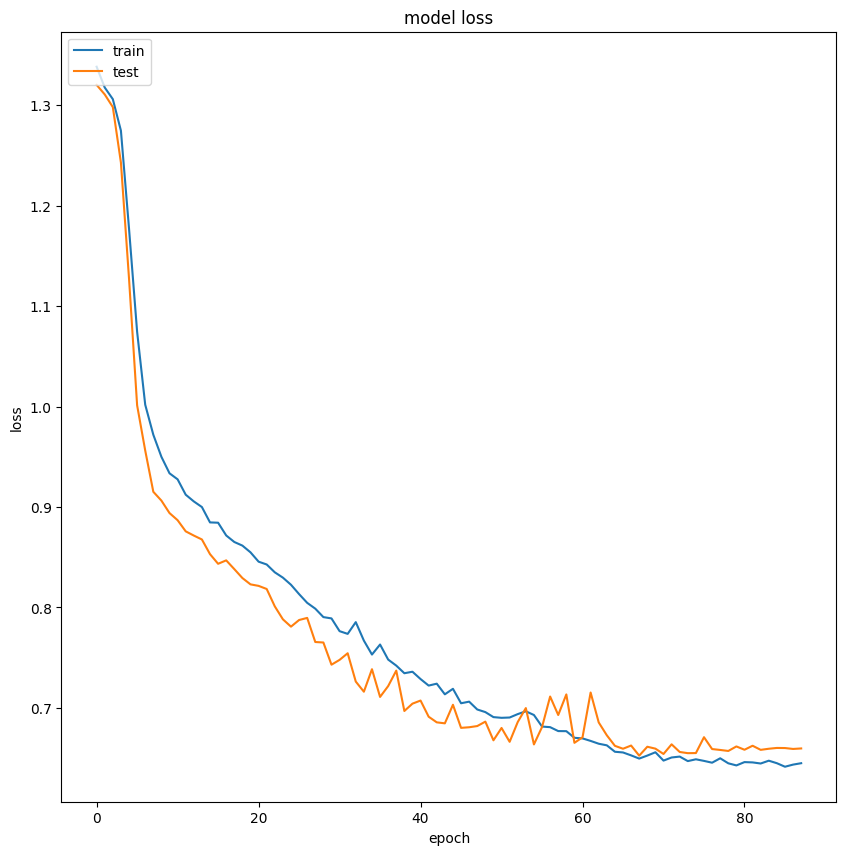

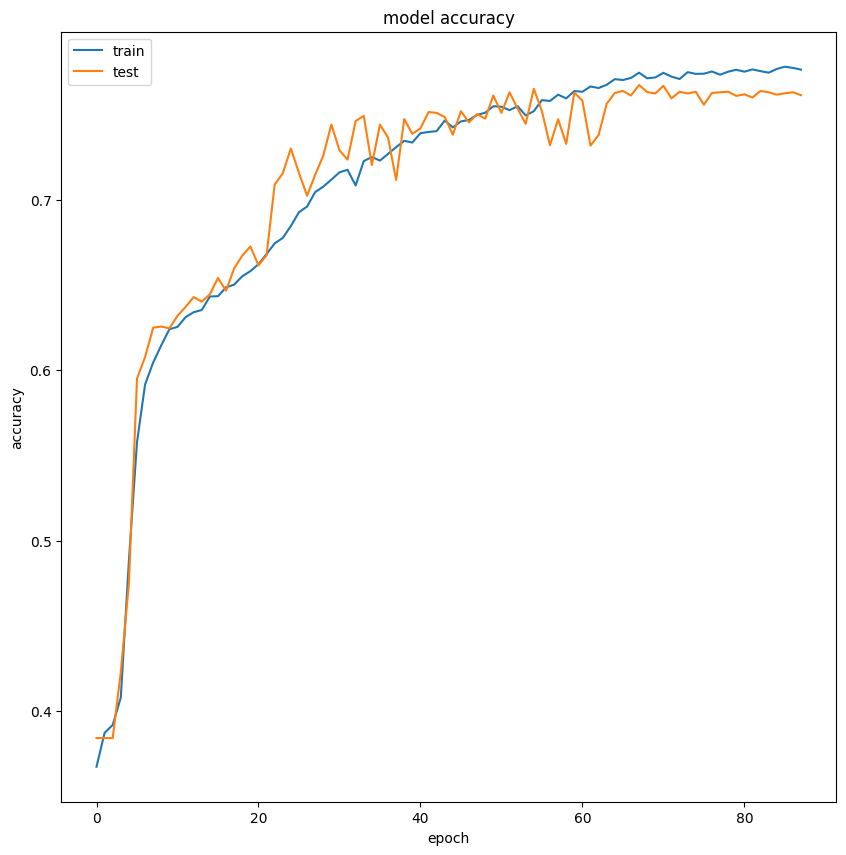

In [13]:
plot_model_history('transformer_history.txt')

Confusion matrix of transformer predictions

2023-02-23 12:12:29.399490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 7s 26ms/step


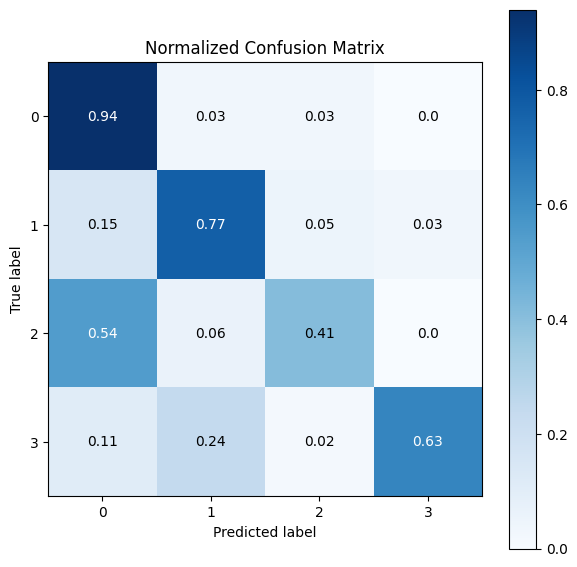

In [14]:
yhat_valid = transformer_model.predict(x_test_transformer)

predicted_classes = np.argmax(yhat_valid, axis=1)

true_classes = y_test_transformer
confuse_fig = scikitplot.metrics.plot_confusion_matrix(
    true_classes,
    predicted_classes,
    normalize='true',
    figsize=(7, 7))
plt.savefig('confusion_matrix.png')

Generate Tableau CSV, ready for import into Tableau. Dashboard available [here](https://public.tableau.com/views/AAI530FinalProject-GPSData/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

In [15]:
generate_tableau_csv()

  1/233 [..............................] - ETA: 2:16

2023-02-23 12:12:41.269240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:12:41.323925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:12:41.355266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-23 12:12:41.394272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 1s 3ms/step


2023-02-23 12:12:42.422704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 7s 26ms/step
